In [2]:
import librosa
import noisereduce as nr
import numpy as np
import pandas as pd
import time
import glob
import os
import shutil
import soundfile as sf
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [3]:
def statistics(y):
    
    mean = np.mean(y)
    std = np.std(y) 
    maxv = np.amax(y) 
    minv = np.amin(y) 
    skew = np.sum((y - mean)**3) / (len(y) * std**3) if std != 0 else 0
    q1 = np.quantile(y, 0.25)
    q3 = np.quantile(y, 0.75)
    
    return np.array([
                     mean, 
                     maxv, 
                     minv, 
                     std, 
                     q1, 
                     q3, 
                     skew, 
                    ])

In [4]:
def spectral(y, feature):
    
    if feature == 'orig':
        return y
    
    elif feature == 'rms':
        return librosa.feature.rms(y=y)[0]
    
    elif feature == 'zcr':
        return librosa.feature.zero_crossing_rate(y=y)[0]
    
    if feature == 'spec_centroid':
        return librosa.feature.spectral_centroid(y=y)[0]
    
    elif feature == 'spec_bandwidth':
        return librosa.feature.spectral_bandwidth(y=y)[0]
    
    elif feature == 'spec_contrast':
        return librosa.feature.spectral_contrast(y=y)[0]
    
    if feature == 'spec_flatness':
        return librosa.feature.spectral_flatness(y=y)[0]
    
    elif feature == 'spec_rolloff':
        return librosa.feature.spectral_rolloff(y=y)[0]
    
    elif feature == 'mfcc':
        return librosa.feature.mfcc(y=y)[0]
    
    elif feature == 'poly_features':
        return librosa.feature.poly_features(y=y)[0]
    
    elif feature == 'melspectrogram':
        return librosa.feature.melspectrogram(y=y)[0]
    
    elif feature == 'chroma_stft':
        return librosa.feature.chroma_stft(y=y)[0]    
        
    elif feature == 'chroma_cqt':
        return librosa.feature.chroma_cqt(y=y)[0]
    
    elif feature == 'chroma_cens':
        return librosa.feature.chroma_cens(y=y)[0]
    
    else:
        print('Invalid feature, choose one from:')
        print('orig', 
              '\nrms', 
              '\nzcr', 
              '\nspec_centroid', 
              '\nspec_contrast', 
              '\nspec_flatness', 
              '\nspec_rolloff', 
              '\nmfcc', 
              '\npoly_features', 
              '\nmelspectrogram',
              '\nchroma_stft',
              '\nchroma_cens')

In [5]:
def feature_stacking(y, features):
    
    temp = []  
    
    for feature in features:
        curr = statistics(spectral(y, feature = feature))
        temp.append(curr)
        
    return np.vstack(temp)

In [6]:
def speech_detection(y, window_size = 10000, stride = 100, threshold = .025):
    moving_avg = []
    for i in range(0, len(y) - window_size + 1, stride):
        window = y[i:i + window_size]
        moving_avg.append(np.mean(window))
    if (np.abs(np.max(moving_avg) - np.min(moving_avg)) * 100) < threshold:
        return False
    else: 
        return True

In [7]:
def sound_module(path):
    
    print(path)
    y, sr = librosa.load(path)
    display(Audio(path))
    plt.plot(y)
    
    S_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref = np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

    reduced_noise = noisereduce.reduce_noise(y=y, sr=sr)
    display(Audio(data = reduced_noise, rate = sr))
    plt.plot(reduced_noise)

In [8]:
def clean_audios(df, language):
    
    os.makedirs(f'{language}_cleaned', exist_ok = True)
    source_directory = f'{language}'
    destination_directory = f'{language}_cleaned'
    count_ignore = 0
    count_fix = 0
    count_untouched = 0
    
    for index in range(len(df)):
        if df['outlier'][index] == 0:
            file_name = df['filename'][index].replace(f"{language}/", "")
            print(f"{index} :: {file_name} not an outlier! Copying and moving to {destination_directory}.")      
            source_path = os.path.join(source_directory, file_name)
            destination_path = os.path.join(destination_directory, file_name)
            shutil.copy(source_path, destination_path)
            count_untouched += 1
        else:
            y, sr = librosa.load(df['filename'][index])
            if speech_detection(y) == False:
                file_name = df['filename'][index].replace(f"{language}/", "")
                print(f"{index} :: {file_name} not a fixable outlier!, moving onto next file.")
                count_ignore += 1
                continue
            else:
                file_name = df['filename'][index].replace(f"{language}/", "")
                print(f"{index} :: {file_name} is a fixable outlier! Fixing and writing it to {destination_directory}.")    
                reduced_noise = nr.reduce_noise(y = y, sr = sr)
                file_path = os.path.join(destination_directory, file_name)
                sf.write(file_path, reduced_noise, samplerate = sr)
                count_fix += 1
    
    print('#########################################') 
    print('#########################################')        
    print('Number of files that were too bad to fix:', count_ignore)
    print('Number of files that were fixable:', count_fix)
    print('Number of files that were left untouched:', count_untouched)
    print('#########################################') 
    print('#########################################') 

In [9]:
features = ['rms', 'zcr', 'spec_flatness', 'mfcc', 'chroma_stft']

In [10]:
language='english_1'

count = 0
files_thrown = []
temp = []

for files in glob.glob(f'{language}/*.mp3'):
    if count % 100 == 0:
        print('Currently at:', files, '->', count, 'out of 1500')   
    try:
        y, sr = librosa.load(files)
    except Exception as e:
        print(f"\nError loading audio file: {e}")
        print(f"Skipping {files} due to an issue with feature stacking.\n")
        files_thrown.append(files)
        continue

    temp.append(feature_stacking(y, features))
    count += 1
    
X = np.stack(temp).reshape(np.stack(temp).shape[0], -1)

Currently at: english_1/common_voice_en_38025119.mp3 -> 0 out of 1500
Currently at: english_1/common_voice_en_37570542.mp3 -> 100 out of 1500
Currently at: english_1/common_voice_en_38081687.mp3 -> 200 out of 1500
Currently at: english_1/common_voice_en_37837525.mp3 -> 300 out of 1500
Currently at: english_1/common_voice_en_37846492.mp3 -> 400 out of 1500
Currently at: english_1/common_voice_en_37921838.mp3 -> 500 out of 1500
Currently at: english_1/common_voice_en_38069677.mp3 -> 600 out of 1500
Currently at: english_1/common_voice_en_38031346.mp3 -> 700 out of 1500
Currently at: english_1/common_voice_en_37911086.mp3 -> 800 out of 1500
Currently at: english_1/common_voice_en_38001534.mp3 -> 900 out of 1500
Currently at: english_1/common_voice_en_37871996.mp3 -> 1000 out of 1500
Currently at: english_1/common_voice_en_37468709.mp3 -> 1100 out of 1500
Currently at: english_1/common_voice_en_37896076.mp3 -> 1200 out of 1500
Currently at: english_1/common_voice_en_37627703.mp3 -> 1300 ou

/Users/shrivats_sudhir/anaconda3/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [11]:
scaler = StandardScaler().fit(X)
pca = PCA(n_components = 3)
components = pca.fit_transform(scaler.transform(X))

# Isolation Forest

In [12]:
clf = IsolationForest(random_state = None, contamination = 0.05).fit(components)
predictions = clf.predict(components)
IF_indices = np.where(predictions == -1)[0]
IF_indices

array([  43,   71,   83,   84,   85,   86,  118,  126,  158,  174,  181,
        187,  188,  283,  288,  306,  308,  370,  399,  414,  457,  459,
        460,  487,  500,  505,  585,  629,  655,  656,  685,  686,  687,
        706,  726,  741,  766,  822,  840,  853,  858,  876,  900,  906,
        909,  917,  920,  921,  967,  978,  996, 1005, 1069, 1076, 1125,
       1130, 1168, 1193, 1208, 1219, 1233, 1275, 1295, 1317, 1331, 1341,
       1383, 1416, 1420, 1424, 1451, 1470, 1474, 1487, 1493])

# Local Outlier Factor

In [13]:
clf = LocalOutlierFactor(n_neighbors = 10, contamination = 0.05)
predictions = clf.fit_predict(components)
LOF_indices = np.where(predictions == -1)[0]
LOF_indices

array([  18,   25,   28,   35,   36,   43,   45,   56,   75,   84,   85,
        114,  126,  158,  166,  174,  181,  187,  283,  295,  308,  320,
        370,  399,  445,  454,  487,  523,  547,  554,  564,  591,  606,
        629,  631,  636,  655,  656,  660,  687,  693,  726,  741,  743,
        745,  758,  822,  840,  853,  858,  909,  917,  921,  952,  967,
        978, 1005, 1029, 1050, 1076, 1120, 1125, 1153, 1174, 1208, 1219,
       1233, 1271, 1295, 1317, 1341, 1397, 1416, 1474, 1482])

In [14]:
print(np.intersect1d(LOF_indices, IF_indices))

[  43   84   85  126  158  174  181  187  283  308  370  399  487  629
  655  656  687  726  741  822  840  853  858  909  917  921  967  978
 1005 1076 1125 1208 1219 1233 1295 1317 1341 1416 1474]


In [15]:
outliers = np.zeros(len(components[:, 0]))
outliers[np.intersect1d(LOF_indices, IF_indices)] = 1
all_files = glob.glob(f'{language}/*.mp3')

for files in files_thrown:
    if files in all_files:
        all_files.remove(files)
        
df = pd.DataFrame({'filename': all_files,
                   'PC1': components[:, 0], 
                   'PC2': components[:, 1], 
                   'PC3': components[:, 2], 
                   'outlier': outliers})
df = df.reset_index(drop = False)

df

,index,filename,PC1,PC2,PC3,outlier
0,0,english_1/common_voice_en_38025119.mp3,0.180562,0.570170,-1.623592,0.0
1,1,english_1/common_voice_en_38003860.mp3,-2.845427,-1.686120,0.831595,0.0
2,2,english_1/common_voice_en_37947001.mp3,1.711032,-0.522184,-1.051171,0.0
3,3,english_1/common_voice_en_38032465.mp3,1.105689,6.742493,-1.599075,0.0
4,4,english_1/common_voice_en_37732911.mp3,0.388003,-1.293758,1.842055,0.0
...,...,...,...,...,...,...
1495,1495,english_1/common_voice_en_38157160.mp3,-3.476290,-1.406220,1.738320,0.0
1496,1496,english_1/common_voice_en_38148040.mp3,-1.082190,0.637848,5.349504,0.0
1497,1497,english_1/common_voice_en_37457260.mp3,0.352629,-3.319026,-2.471138,0.0
1498,1498,english_1/common_voice_en_37478283.mp3,-0.638343,1.214700,-0.079753,0.0


In [33]:
def axes_style3d(bgcolor = "rgb(20, 20, 20)",
                 gridcolor="rgb(150, 150, 150)", 
                 zeroline=False): 
    return dict(showbackground =True,
                backgroundcolor=bgcolor,
                gridcolor=gridcolor,
                zeroline=False)

my_axes =  axes_style3d()  #black background color  

fig = px.scatter_3d(df, x = 'PC1', y = 'PC2', z = 'PC3',
                    color='outlier', hover_name = "index", opacity = 0.5)

fig.update_traces(marker = dict(size = 7),
                  selector = dict(mode='markers'))

fig.update_layout(margin=dict(t=2, r=2, b=2, l=2),
                   scene=dict(xaxis=my_axes, 
                             yaxis=my_axes, 
                             zaxis=my_axes,
                             camera_eye=dict(x=1.5, y=1.5, z=1)))

fig.show()
fig.write_html("outlier_detection.html")

In [17]:
clean_audios(df = df, language = language)

0 :: common_voice_en_38025119.mp3 not an outlier! Copying and moving to english_1_cleaned.
1 :: common_voice_en_38003860.mp3 not an outlier! Copying and moving to english_1_cleaned.
2 :: common_voice_en_37947001.mp3 not an outlier! Copying and moving to english_1_cleaned.
3 :: common_voice_en_38032465.mp3 not an outlier! Copying and moving to english_1_cleaned.
4 :: common_voice_en_37732911.mp3 not an outlier! Copying and moving to english_1_cleaned.
5 :: common_voice_en_37888102.mp3 not an outlier! Copying and moving to english_1_cleaned.
6 :: common_voice_en_37306843.mp3 not an outlier! Copying and moving to english_1_cleaned.
7 :: common_voice_en_38176555.mp3 not an outlier! Copying and moving to english_1_cleaned.
8 :: common_voice_en_38034014.mp3 not an outlier! Copying and moving to english_1_cleaned.
9 :: common_voice_en_38130500.mp3 not an outlier! Copying and moving to english_1_cleaned.
10 :: common_voice_en_38089595.mp3 not an outlier! Copying and moving to english_1_cleaned

182 :: common_voice_en_37861788.mp3 not an outlier! Copying and moving to english_1_cleaned.
183 :: common_voice_en_37604247.mp3 not an outlier! Copying and moving to english_1_cleaned.
184 :: common_voice_en_38031622.mp3 not an outlier! Copying and moving to english_1_cleaned.
185 :: common_voice_en_38058694.mp3 not an outlier! Copying and moving to english_1_cleaned.
186 :: common_voice_en_37389380.mp3 not an outlier! Copying and moving to english_1_cleaned.
187 :: common_voice_en_37614054.mp3 is a fixable outlier! Fixing and writing it to english_1_cleaned.
188 :: common_voice_en_38125125.mp3 not an outlier! Copying and moving to english_1_cleaned.
189 :: common_voice_en_37892614.mp3 not an outlier! Copying and moving to english_1_cleaned.
190 :: common_voice_en_37942637.mp3 not an outlier! Copying and moving to english_1_cleaned.
191 :: common_voice_en_37465601.mp3 not an outlier! Copying and moving to english_1_cleaned.
192 :: common_voice_en_38017183.mp3 not an outlier! Copying a

371 :: common_voice_en_38081136.mp3 not an outlier! Copying and moving to english_1_cleaned.
372 :: common_voice_en_37532942.mp3 not an outlier! Copying and moving to english_1_cleaned.
373 :: common_voice_en_38131839.mp3 not an outlier! Copying and moving to english_1_cleaned.
374 :: common_voice_en_37376383.mp3 not an outlier! Copying and moving to english_1_cleaned.
375 :: common_voice_en_37289343.mp3 not an outlier! Copying and moving to english_1_cleaned.
376 :: common_voice_en_37515325.mp3 not an outlier! Copying and moving to english_1_cleaned.
377 :: common_voice_en_38080228.mp3 not an outlier! Copying and moving to english_1_cleaned.
378 :: common_voice_en_37970652.mp3 not an outlier! Copying and moving to english_1_cleaned.
379 :: common_voice_en_37929727.mp3 not an outlier! Copying and moving to english_1_cleaned.
380 :: common_voice_en_38022689.mp3 not an outlier! Copying and moving to english_1_cleaned.
381 :: common_voice_en_38111531.mp3 not an outlier! Copying and moving

630 :: common_voice_en_37859015.mp3 not an outlier! Copying and moving to english_1_cleaned.
631 :: common_voice_en_38132897.mp3 not an outlier! Copying and moving to english_1_cleaned.
632 :: common_voice_en_37904474.mp3 not an outlier! Copying and moving to english_1_cleaned.
633 :: common_voice_en_37465417.mp3 not an outlier! Copying and moving to english_1_cleaned.
634 :: common_voice_en_37364220.mp3 not an outlier! Copying and moving to english_1_cleaned.
635 :: common_voice_en_37942421.mp3 not an outlier! Copying and moving to english_1_cleaned.
636 :: common_voice_en_37527156.mp3 not an outlier! Copying and moving to english_1_cleaned.
637 :: common_voice_en_37996116.mp3 not an outlier! Copying and moving to english_1_cleaned.
638 :: common_voice_en_37913108.mp3 not an outlier! Copying and moving to english_1_cleaned.
639 :: common_voice_en_37935871.mp3 not an outlier! Copying and moving to english_1_cleaned.
640 :: common_voice_en_37849206.mp3 not an outlier! Copying and moving

822 :: common_voice_en_37944905.mp3 is a fixable outlier! Fixing and writing it to english_1_cleaned.
823 :: common_voice_en_37387636.mp3 not an outlier! Copying and moving to english_1_cleaned.
824 :: common_voice_en_37414563.mp3 not an outlier! Copying and moving to english_1_cleaned.
825 :: common_voice_en_38114663.mp3 not an outlier! Copying and moving to english_1_cleaned.
826 :: common_voice_en_38011069.mp3 not an outlier! Copying and moving to english_1_cleaned.
827 :: common_voice_en_37550453.mp3 not an outlier! Copying and moving to english_1_cleaned.
828 :: common_voice_en_38040540.mp3 not an outlier! Copying and moving to english_1_cleaned.
829 :: common_voice_en_37740834.mp3 not an outlier! Copying and moving to english_1_cleaned.
830 :: common_voice_en_37474297.mp3 not an outlier! Copying and moving to english_1_cleaned.
831 :: common_voice_en_38124978.mp3 not an outlier! Copying and moving to english_1_cleaned.
832 :: common_voice_en_38220218.mp3 not an outlier! Copying a

918 :: common_voice_en_38059039.mp3 not an outlier! Copying and moving to english_1_cleaned.
919 :: common_voice_en_37499109.mp3 not an outlier! Copying and moving to english_1_cleaned.
920 :: common_voice_en_38124950.mp3 not an outlier! Copying and moving to english_1_cleaned.
921 :: common_voice_en_37846848.mp3 not a fixable outlier!, moving onto next file.
922 :: common_voice_en_38031391.mp3 not an outlier! Copying and moving to english_1_cleaned.
923 :: common_voice_en_37615821.mp3 not an outlier! Copying and moving to english_1_cleaned.
924 :: common_voice_en_38153500.mp3 not an outlier! Copying and moving to english_1_cleaned.
925 :: common_voice_en_38011041.mp3 not an outlier! Copying and moving to english_1_cleaned.
926 :: common_voice_en_37434843.mp3 not an outlier! Copying and moving to english_1_cleaned.
927 :: common_voice_en_37913875.mp3 not an outlier! Copying and moving to english_1_cleaned.
928 :: common_voice_en_37386500.mp3 not an outlier! Copying and moving to englis

1220 :: common_voice_en_38028763.mp3 not an outlier! Copying and moving to english_1_cleaned.
1221 :: common_voice_en_37698318.mp3 not an outlier! Copying and moving to english_1_cleaned.
1222 :: common_voice_en_37672919.mp3 not an outlier! Copying and moving to english_1_cleaned.
1223 :: common_voice_en_37882017.mp3 not an outlier! Copying and moving to english_1_cleaned.
1224 :: common_voice_en_37859613.mp3 not an outlier! Copying and moving to english_1_cleaned.
1225 :: common_voice_en_37396868.mp3 not an outlier! Copying and moving to english_1_cleaned.
1226 :: common_voice_en_37999423.mp3 not an outlier! Copying and moving to english_1_cleaned.
1227 :: common_voice_en_38007958.mp3 not an outlier! Copying and moving to english_1_cleaned.
1228 :: common_voice_en_37974795.mp3 not an outlier! Copying and moving to english_1_cleaned.
1229 :: common_voice_en_37389790.mp3 not an outlier! Copying and moving to english_1_cleaned.
1230 :: common_voice_en_37816104.mp3 not an outlier! Copying

1490 :: common_voice_en_38047401.mp3 not an outlier! Copying and moving to english_1_cleaned.
1491 :: common_voice_en_38220436.mp3 not an outlier! Copying and moving to english_1_cleaned.
1492 :: common_voice_en_37841921.mp3 not an outlier! Copying and moving to english_1_cleaned.
1493 :: common_voice_en_38001454.mp3 not an outlier! Copying and moving to english_1_cleaned.
1494 :: common_voice_en_37349577.mp3 not an outlier! Copying and moving to english_1_cleaned.
1495 :: common_voice_en_38157160.mp3 not an outlier! Copying and moving to english_1_cleaned.
1496 :: common_voice_en_38148040.mp3 not an outlier! Copying and moving to english_1_cleaned.
1497 :: common_voice_en_37457260.mp3 not an outlier! Copying and moving to english_1_cleaned.
1498 :: common_voice_en_37478283.mp3 not an outlier! Copying and moving to english_1_cleaned.
1499 :: common_voice_en_37936203.mp3 not an outlier! Copying and moving to english_1_cleaned.
#########################################
##################

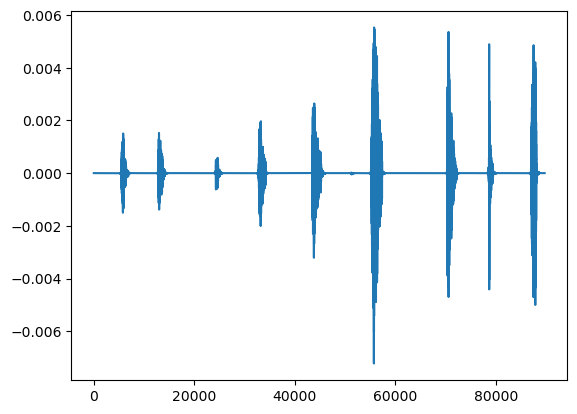

In [35]:
y, sr = librosa.load('english_1/common_voice_en_38029092.mp3')
plt.plot(y)

In [36]:
display(Audio('english_1/common_voice_en_38029092.mp3'))